In [14]:
# --- Invariant subspace extraction for Rule 20 (ECA) ---
import numpy as np, itertools, collections
from collections import defaultdict
from eca import ECA
from lasalle import PhaseSpace

In [2]:
# Parameters
RULE = 20
n = 12       # ring size (keep modest to allow exhaustive search)
k = 1        # phase order; k>=1 enables edge/2-cycle diagnostics

eca = ECA(RULE)
C = eca.get_neighborhoods(n)
print(f"Using Rule {RULE} with bits (111..000): {''.join('1' if b else '0' for b in eca.bits)}")


Using Rule 20 with bits (111..000): 00010100


In [3]:
# --- Helper: iterate map ---
def F(x): 
    return eca.iterate(x, C=C)

# --- LaSalle weights on triples (from 5-block transfer graph) ---
TRIPLES = [(1,1,1),(1,1,0),(1,0,1),(1,0,0),(0,1,1),(0,1,0),(0,0,1),(0,0,0)]
IDX = {t:i for i,t in enumerate(TRIPLES)}
def local_bit(rule_bits, triple):
    return int(rule_bits[IDX[tuple(triple)]])

def lasalle_weights(rule_bits):
    edges=set()
    for b in itertools.product([0,1], repeat=5):
        k  = IDX[(b[1],b[2],b[3])]
        kp = IDX[(local_bit(rule_bits, b[:3]),
                  local_bit(rule_bits, b[1:4]),
                  local_bit(rule_bits, b[2:5]))]
        edges.add((k,kp))
    # SCC condense and assign longest distance to sinks
    n8=8
    G=[[] for _ in range(n8)]
    GR=[[] for _ in range(n8)]
    for u,v in edges:
        G[u].append(v); GR[v].append(u)
    seen=[0]*n8; order=[]
    def dfs(u):
        seen[u]=1
        for v in G[u]:
            if not seen[v]:
                dfs(v)
        order.append(u)
    for u in range(n8):
        if not seen[u]:
            dfs(u)
    comp=[-1]*n8
    def rdfs(u,L):
        comp[u]=L
        for v in GR[u]:
            if comp[v]<0:
                rdfs(v,L)
    L=0
    for u in reversed(order):
        if comp[u]<0:
            rdfs(u,L); L+=1
    dag=set()
    for u,v in edges:
        if comp[u]!=comp[v]:
            dag.add((comp[u],comp[v]))
    kids=[[] for _ in range(L)]
    indeg=[0]*L
    for u,v in dag:
        kids[u].append(v); indeg[v]+=1
    from collections import deque
    q=deque([u for u in range(L) if indeg[u]==0]); topo=[]
    while q:
        u=q.popleft(); topo.append(u)
        for v in kids[u]:
            indeg[v]-=1
            if indeg[v]==0:
                q.append(v)
    w_comp=[0]*L
    for u in reversed(topo):
        w_comp[u] = 0 if not kids[u] else 1+max(w_comp[v] for v in kids[u])
    w = np.array([w_comp[comp[k]] for k in range(n8)], dtype=int)
    # classify 5-blocks
    allowed=[]; disallowed=[]
    for b in itertools.product([0,1], repeat=5):
        k  = IDX[(b[1],b[2],b[3])]
        kp = IDX[(local_bit(rule_bits, b[:3]),
                  local_bit(rule_bits, b[1:4]),
                  local_bit(rule_bits, b[2:5]))]
        (allowed if w[kp]==w[k] else disallowed).append(b)
    return w, allowed, disallowed



In [4]:
w, allowed5, disallowed5 = lasalle_weights(eca.bits.astype(int))
print("LaSalle weights w (order of triples 111,110,101,100,011,010,001,000):", w.tolist())
print("Disallowed 5-blocks (strict V decrease):", disallowed5)

# --- Build the LaSalle equality set E (no disallowed 5-block anywhere on the ring) ---
def windows5(x):
    return [(int(x[(i-2)%n]), int(x[(i-1)%n]), int(x[i]), int(x[(i+1)%n]), int(x[(i+2)%n])) for i in range(n)]

def in_E(x):
    return all(tuple(win) not in disallowed5 for win in windows5(x))


LaSalle weights w (order of triples 111,110,101,100,011,010,001,000): [1, 0, 0, 0, 0, 0, 0, 0]
Disallowed 5-blocks (strict V decrease): [(0, 1, 1, 1, 0), (0, 1, 1, 1, 1), (1, 1, 1, 1, 0), (1, 1, 1, 1, 1)]


In [5]:

# Enumerate all states (2^n); collect E and its largest invariant subset under F
E_states=[]
for m in range(1<<n):
    bits = np.array([(m>>j)&1 for j in range(n)], dtype=bool)  # little-endian indices
    if in_E(bits):
        E_states.append(bits)
E_states = np.array(E_states, dtype=bool)
print(f"|E| (no bad 5-blocks) = {len(E_states)} out of {1<<n}")


|E| (no bad 5-blocks) = 1499 out of 4096


In [6]:
# Largest invariant subset S ⊆ E via closure under F
E_set = {tuple(row.tolist()) for row in E_states}
S = set(E_set)
changed=True
while changed:
    changed=False
    to_remove=set()
    for s in S:
        x = np.array(s, dtype=bool)
        y = F(x)
        if tuple(y.tolist()) not in S:
            to_remove.add(s)
    if to_remove:
        S -= to_remove
        changed=True

print(f"|S| (largest invariant subset of E) = {len(S)}")
def to_str(x): return ''.join('1' if b else '0' for b in x.astype(int))


|S| (largest invariant subset of E) = 1499


In [7]:
# --- Extract fixed points and 2-cycles (projected to base space) ---
def find_cycles():
    seen=set()
    fixed=[]
    twos=set()
    for m in range(1<<n):
        x = np.array([(m>>j)&1 for j in range(n)], dtype=bool)
        if tuple(x.tolist()) in seen: 
            continue
        x1 = F(x)
        if np.array_equal(x1, x):
            fixed.append(x)
            seen.add(tuple(x.tolist()))
        else:
            x2 = F(x1)
            if np.array_equal(x2, x):
                a = tuple(x.tolist()); b = tuple(x1.tolist())
                rep = min(a,b)  # canonicalize 2-cycle
                if rep not in twos:
                    twos.add(rep)
                seen.add(a); seen.add(b)
    return fixed, [np.array(list(t), dtype=bool) for t in sorted(twos)]

fixed_points, two_cycles = find_cycles()
print(f"Fixed points: {len(fixed_points)}")
print("  Examples:", [to_str(x) for x in fixed_points[:min(5,len(fixed_points))]])
print(f"2-cycles (distinct pairs): {len(two_cycles)}")
print("  Examples (representatives):", [to_str(x) for x in two_cycles[:min(5,len(two_cycles))]])


Fixed points: 3
  Examples: ['000000000000', '101010101010', '010101010101']
2-cycles (distinct pairs): 0
  Examples (representatives): []


In [8]:

# --- Optional: Phase-space invariants (k=1) ---
if PhaseSpace is not None and k>=1:
    ps = PhaseSpace(eca, n=n, k=1)
    # Build (x, δ) pairs that are fixed by the phase map (δ^+ = δ), which project to 2-cycles in base space.
    two_phase=[]
    for m in range(1<<n):
        x = np.array([(m>>j)&1 for j in range(n)], dtype=bool)
        x1 = F(x)
        d  = x1 ^ x
        x_plus = x ^ d
        d_plus = F(x_plus) ^ x_plus
        if np.array_equal(d_plus, d) and d.any():
            two_phase.append( (x, d) )
    print(f"Phase fixed-set edges (δ fixed, δ≠0): {len(two_phase)}")
    if two_phase:
        x, d = two_phase[0]
        print("  Example x    :", to_str(x))
        print("          δ    :", to_str(d))
        print("          x^+  :", to_str(x ^ d))


Phase fixed-set edges (δ fixed, δ≠0): 0


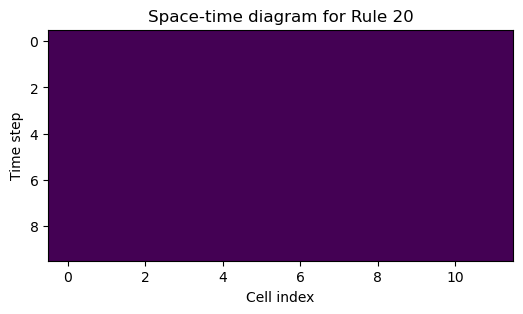

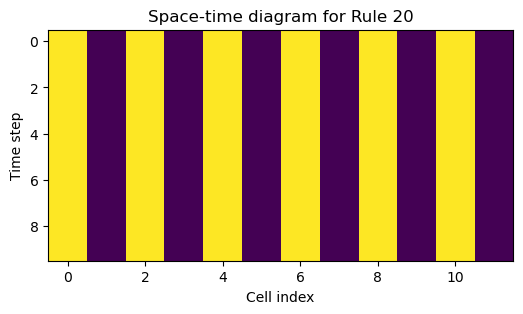

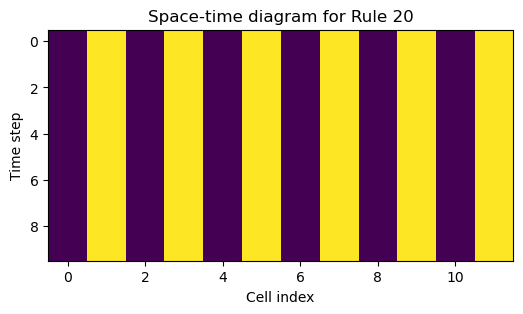

In [9]:
for bitstring in fixed_points:
    xstar = np.array([int(b) for b in bitstring], dtype=bool)
    eca.space_time(xstar, steps=10)

In [11]:
# n same as above
# Rule same as above
k=3
ps3 = PhaseSpace(eca, n=n, k=k)

def detect_min_period_power2(x, F, maxpow=3):
    for p in (1, 2, 4, 8)[:maxpow+1]:
        y = x.copy()
        for _ in range(p):
            y = F(y)
        if np.array_equal(y, x):
            # ensure minimal among divisors
            for q in (1, 2, 4):
                if q < p and p % q == 0:
                    z = x.copy()
                    for _ in range(q):
                        z = F(z)
                    if np.array_equal(z, x):
                        break
            else:
                return p
    return None

In [12]:
print(f"Rule {RULE} bits (111..000): {''.join('1' if b else '0' for b in eca.bits)}")
print(f"Phase order k={k}, n={n}, phase shape={ps3.shape}")

# ---------- helpers ----------

def layers_from_x(x):
    "order-k layers at time t: rows [x, δ, Δ², Δ³]"
    return ps3.init_from_x(x)

def phase_step(layers):
    "one Φ_k step on layers"
    return ps3.step(layers)

# ---------- enumerate all base states ----------
def it_all_states(n):
    for m in range(1 << n):
        yield np.array([(m >> j) & 1 for j in range(n)], dtype=bool)

Rule 20 bits (111..000): 00010100
Phase order k=3, n=12, phase shape=(4, 12)


In [16]:
period_counts = defaultdict(int)
examples      = {1: None, 2: None, 4: None, 8: None}
layers_cache  = []      # collect reachable order-3 phase states from base x
top_fix_set   = set()   # {(flattened layers,) where Δ³ is fixed under Φ_k}
top_fix_next  = dict()  # layer -> step(layer) for closure

for x in it_all_states(n):
    p = detect_min_period_power2(x, maxpow=3, F=F)
    period_counts[p] += 1
    if p in examples and examples[p] is None:
        examples[p] = x.copy()

    L = layers_from_x(x)            # (k+1, n)
    Lp = phase_step(L)
    layers_cache.append(L)

    # "Δ³ fixed" equality set in phase space:
    if np.array_equal(Lp[k], L[k]):
        key  = tuple(L.reshape(-1).tolist())
        keyp = tuple(Lp.reshape(-1).tolist())
        top_fix_set.add(key)
        top_fix_next[key] = keyp

total_states = 1 << n
print("\n=== Minimal period among {1,2,4,8} ===")
for p in (1,2,4,8,None):
    cnt = period_counts[p]
    label = f"period={p}" if p is not None else "period>8"
    print(f"{label:>10}: {cnt:6d}  ({cnt/total_states:6.2%})")

def bstr(x): return ''.join('1' if b else '0' for b in x.astype(int))

print("\nExamples:")
for p in (1,2,4,8):
    if examples[p] is not None:
        print(f"  p={p}: {bstr(examples[p])}")



=== Minimal period among {1,2,4,8} ===
  period=1:      3  ( 0.07%)
  period=2:      0  ( 0.00%)
  period=4:      8  ( 0.20%)
  period=8:      0  ( 0.00%)
  period>8:   4085  (99.73%)

Examples:
  p=1: 000000000000
  p=4: 100010001000


In [17]:
# ---------- largest invariant subset inside {Δ³ fixed} ----------
# We only consider layers that are *reachable* from some base x (via init_from_x),
# then intersect with the Δ³-fixed set, and finally shrink by closure.
print("\n=== Phase-space: Δ³ fixed equality set & largest invariant subset ===")
E = set()
for L in layers_cache:
    Lp = phase_step(L)
    if np.array_equal(Lp[k], L[k]):
        E.add(tuple(L.reshape(-1).tolist()))
print(f"|E|  (Δ³ fixed, reachable layers)       = {len(E)}")

# Closure: keep only those whose step stays in E
S = set(E)
changed = True
while changed:
    changed = False
    to_remove = set()
    for l in S:
        lp = top_fix_next.get(l, None)
        if lp is None or lp not in S:
            to_remove.add(l)
    if to_remove:
        S -= to_remove
        changed = True
print(f"|S|  (largest invariant subset of E)    = {len(S)}")



=== Phase-space: Δ³ fixed equality set & largest invariant subset ===
|E|  (Δ³ fixed, reachable layers)       = 11
|S|  (largest invariant subset of E)    = 11


In [27]:

# ---------- sanity: project S back to base states and inspect periods ----------
proj_periods = defaultdict(int)
reps = []
for l in S:
    L = np.array(l, dtype=bool).reshape(k+1, n)
    x0 = L[0]
    p  = detect_min_period_power2(x0, maxpow=3, F=F)
    proj_periods[p] += 1
    if len(reps) < 10:
        reps.append((p, bstr(x0)))

print("\nProjection of S to base states (period histogram):")
for p in (1,2,4,8,None):
    print(f"  p={p}: {proj_periods[p]}")

print("\nSample representatives from S (p, x):")
for p, s in reps:
    print(" ", p, s)



Projection of S to base states (period histogram):
  p=1: 3
  p=2: 0
  p=4: 8
  p=8: 0
  p=None: 0

Sample representatives from S (p, x):
  4 000100010001
  4 100110011001
  4 011001100110
  4 010001000100
  1 010101010101
  1 101010101010
  4 001100110011
  4 100010001000
  4 001000100010
  4 110011001100


In [28]:
reps

[(4, '000100010001'),
 (4, '100110011001'),
 (4, '011001100110'),
 (4, '010001000100'),
 (1, '010101010101'),
 (1, '101010101010'),
 (4, '001100110011'),
 (4, '100010001000'),
 (4, '001000100010'),
 (4, '110011001100')]

Cycle length: 4
Bitstring: 000100010001


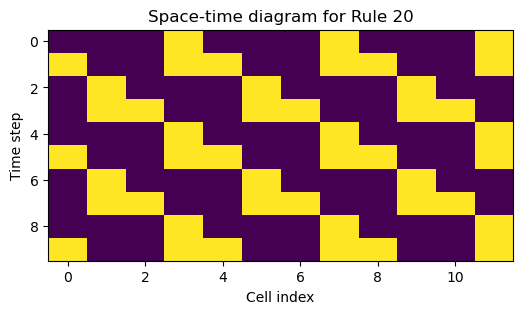

Cycle length: 4
Bitstring: 100110011001


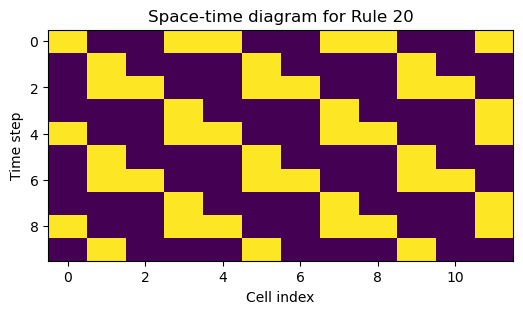

Cycle length: 4
Bitstring: 011001100110


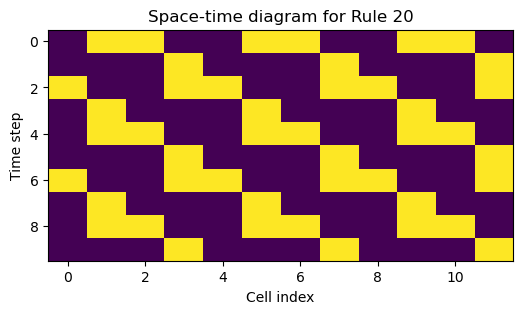

Cycle length: 4
Bitstring: 010001000100


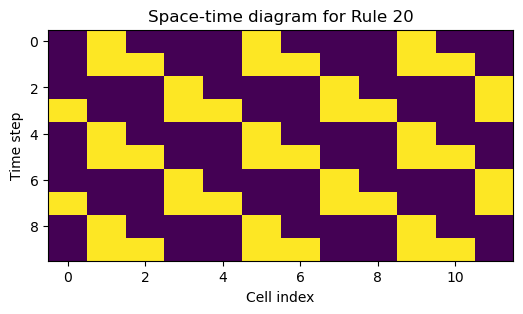

Cycle length: 1
Bitstring: 010101010101


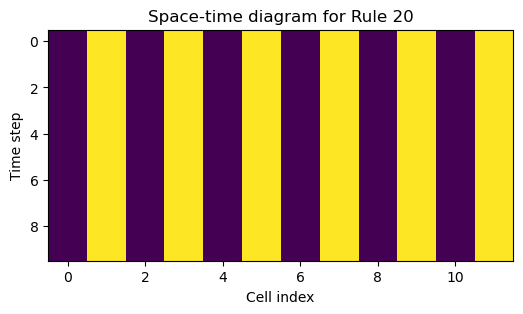

Cycle length: 1
Bitstring: 101010101010


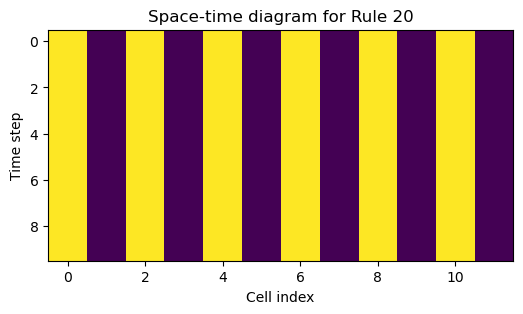

Cycle length: 4
Bitstring: 001100110011


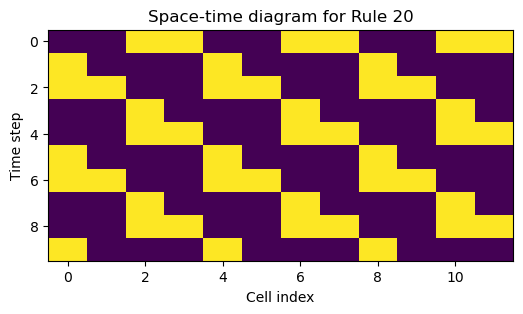

Cycle length: 4
Bitstring: 100010001000


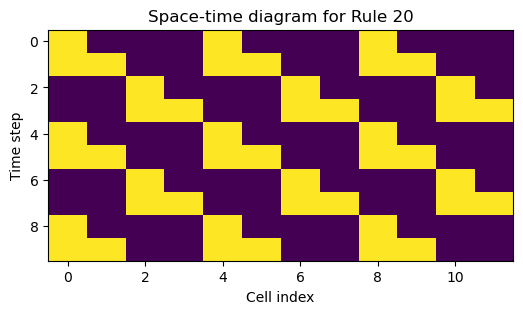

Cycle length: 4
Bitstring: 001000100010


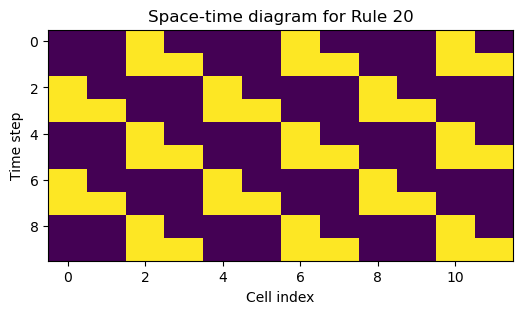

Cycle length: 4
Bitstring: 110011001100


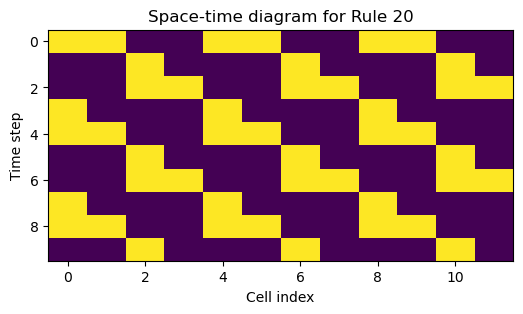

In [29]:
for cycle_length, bitstring in reps:
    print(f"Cycle length: {cycle_length}")
    print(f"Bitstring: {bitstring}")
    xstar = np.array([int(b) for b in bitstring], dtype=bool)
    eca.space_time(xstar, steps=10)
    print("==="*20)